## Result Analysis and Visuals

In [6]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from collections import defaultdict
import os
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['figure.dpi'] = 300

model_colors = {
    "Dummy": "#E1E1E1",
    "LogisticRegression": "#6EB5FF", 
    "Ridge": "#6EB5FF",
    "XGBRegressor": "#3D85C6",
    "XGBClassifier": "#3D85C6",
    "glot500": "#073763"
}

# Color scheme for languages
language_colors = {
    "ar": "#C44E52",  # Arabic - red
    "en": "#4C72B0",  # English - blue
    "fi": "#55A868",  # Finnish - green
    "id": "#8172B3",  # Indonesian - purple
    "ja": "#CCB974",  # Japanese - yellow
    "ko": "#64B5CD",  # Korean - teal
    "ru": "#DB8E00"   # Russian - orange
}

# Sequential color map for heatmaps
cmap_blues = LinearSegmentedColormap.from_list(
    "custom_blues", ["#FFFFFF", "#EBF1F9", "#D6E3F3", "#C1D6ED", "#ADCAE7", "#98BDE0", "#83B0DA", "#6EA4D4", "#5997CE", "#448BC8", "#2F7EC2"]
)

# Load the combined results file
with open('combined_results/combined_results.json', 'r') as f:
    results = json.load(f)

# Let's first understand what experiments we have
experiment_configs = {}
for exp_key in results.keys():
    parts = exp_key.split('_')
    source = parts[0]  # e.g., tfidf
    model = '_'.join(parts[1:-2]) if 'control' in parts[-2] else '_'.join(parts[1:-1])  # e.g., XGBRegressor
    task = parts[-2] if 'control' in parts[-2] else parts[-1]  # e.g., complexity or question_type
    control_info = parts[-1] if 'control' in parts[-1] else None  # e.g., control1, control2, etc.
    
    if task not in experiment_configs:
        experiment_configs[task] = set()
    
    if control_info:
        experiment_configs[task].add(f"{source}_{model}_{control_info}")
    else:
        experiment_configs[task].add(f"{source}_{model}")

# Print the experiment configurations
print("Experiment Configurations:")
for task, configs in experiment_configs.items():
    print(f"\n{task.upper()}:")
    for config in sorted(configs):
        print(f"  - {config}")

# Extract available languages and control indices
languages = set()
control_indices = set()
submetrics = set()

for exp_data in results.values():
    langs = exp_data.get('languages', [])
    for lang in langs:
        languages.add(lang)
    
    control_idx = exp_data.get('control_index')
    if control_idx is not None:
        control_indices.add(control_idx)
    
    submetric = exp_data.get('submetric')
    if submetric is not None:
        submetrics.add(submetric)

print(f"\nLanguages: {sorted(languages)}")
print(f"Control Indices: {sorted(control_indices)}")
print(f"Submetrics: {sorted(submetrics)}")

Experiment Configurations:

DEPTH:
  - tfidf_Ridge_complexity_avg_max
  - tfidf_Ridge_complexity_control1_avg_max
  - tfidf_Ridge_complexity_control2_avg_max
  - tfidf_Ridge_complexity_control3_avg_max
  - tfidf_XGBRegressor_complexity_avg_max
  - tfidf_XGBRegressor_complexity_control1_avg_max
  - tfidf_XGBRegressor_complexity_control2_avg_max
  - tfidf_XGBRegressor_complexity_control3_avg_max

TOKENS:
  - tfidf_Ridge_complexity_control1_n
  - tfidf_Ridge_complexity_control2_n
  - tfidf_Ridge_complexity_control3_n
  - tfidf_Ridge_complexity_n
  - tfidf_XGBRegressor_complexity_control1_n
  - tfidf_XGBRegressor_complexity_control2_n
  - tfidf_XGBRegressor_complexity_control3_n
  - tfidf_XGBRegressor_complexity_n

CONTROL2:
  - tfidf_DummyClassifier_question_type_control2
  - tfidf_DummyRegressor_complexity_control2
  - tfidf_LogisticRegression_question_type_control2
  - tfidf_Ridge_complexity_control2
  - tfidf_XGBClassifier_question_type_control2
  - tfidf_XGBRegressor_complexity_contro

In [7]:
complexity_results = []
question_type_results = []

for exp_key, exp_data in results.items():
    task = exp_data.get('task')
    model_type = exp_data.get('model_type')
    control_index = exp_data.get('control_index')
    submetric = exp_data.get('submetric', 'None')
    source = exp_data.get('source', 'Unknown')
    
    # Extract metrics for different splits
    train_metrics = exp_data.get('train_metrics', {})
    val_metrics = exp_data.get('val_metrics', {})
    test_metrics = exp_data.get('test_metrics', {})
    
    row = {
        'experiment': exp_key,
        'task': task,
        'model_type': model_type,
        'control_index': control_index,
        'submetric': submetric,
        'source': source,
        'training_time': exp_data.get('training_time', 0)
    }
    
    # Add metrics based on task type
    if task == 'complexity':
        for split, metrics in [('train', train_metrics), ('val', val_metrics), ('test', test_metrics)]:
            for metric, value in metrics.items():
                row[f'{split}_{metric}'] = value
        complexity_results.append(row)
    elif task == 'question_type':
        for split, metrics in [('train', train_metrics), ('val', val_metrics), ('test', test_metrics)]:
            for metric, value in metrics.items():
                row[f'{split}_{metric}'] = value
        question_type_results.append(row)

# Convert to DataFrames
complexity_df = pd.DataFrame(complexity_results)
question_type_df = pd.DataFrame(question_type_results)

# Display basic statistics
print("\n=== COMPLEXITY TASK STATISTICS ===")
if not complexity_df.empty:
    print(f"Number of experiments: {len(complexity_df)}")
    print("\nModel types:")
    print(complexity_df['model_type'].value_counts())
    
    print("\nSubmetrics:")
    print(complexity_df['submetric'].value_counts())
    
    print("\nTest RMSE statistics:")
    print(complexity_df['test_rmse'].describe())
    
    print("\nTest R² statistics:")
    print(complexity_df['test_r2'].describe())
    
    print("\nTraining time statistics (seconds):")
    print(complexity_df['training_time'].describe())
    
print("\n=== QUESTION TYPE TASK STATISTICS ===")
if not question_type_df.empty:
    print(f"Number of experiments: {len(question_type_df)}")
    print("\nModel types:")
    print(question_type_df['model_type'].value_counts())
    
    print("\nTest accuracy statistics:")
    print(question_type_df['test_accuracy'].describe())
    
    print("\nTest F1 statistics:")
    print(question_type_df['test_f1'].describe())
    
    print("\nTraining time statistics (seconds):")
    print(question_type_df['training_time'].describe())



=== COMPLEXITY TASK STATISTICS ===
Number of experiments: 216

Model types:
model_type
lm_probe          156
Ridge              28
XGBRegressor       28
DummyRegressor      4
Name: count, dtype: int64

Submetrics:
submetric
None                         154
avg_max_depth                  8
n_tokens                       8
avg_subordinate_chain_len      8
avg_verb_edges                 8
lexical_density                8
avg_links_len                  8
Name: count, dtype: int64

Test RMSE statistics:
count    171.000000
mean       0.229208
std        0.052310
min        0.143195
25%        0.198147
50%        0.217222
75%        0.250104
max        0.446107
Name: test_rmse, dtype: float64

Test R² statistics:
count    171.000000
mean      -0.277903
std        0.646163
min       -4.670323
25%       -0.268992
50%       -0.101957
75%       -0.015682
max        0.535843
Name: test_r2, dtype: float64

Training time statistics (seconds):
count    216.000000
mean      21.413529
std       55.58

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

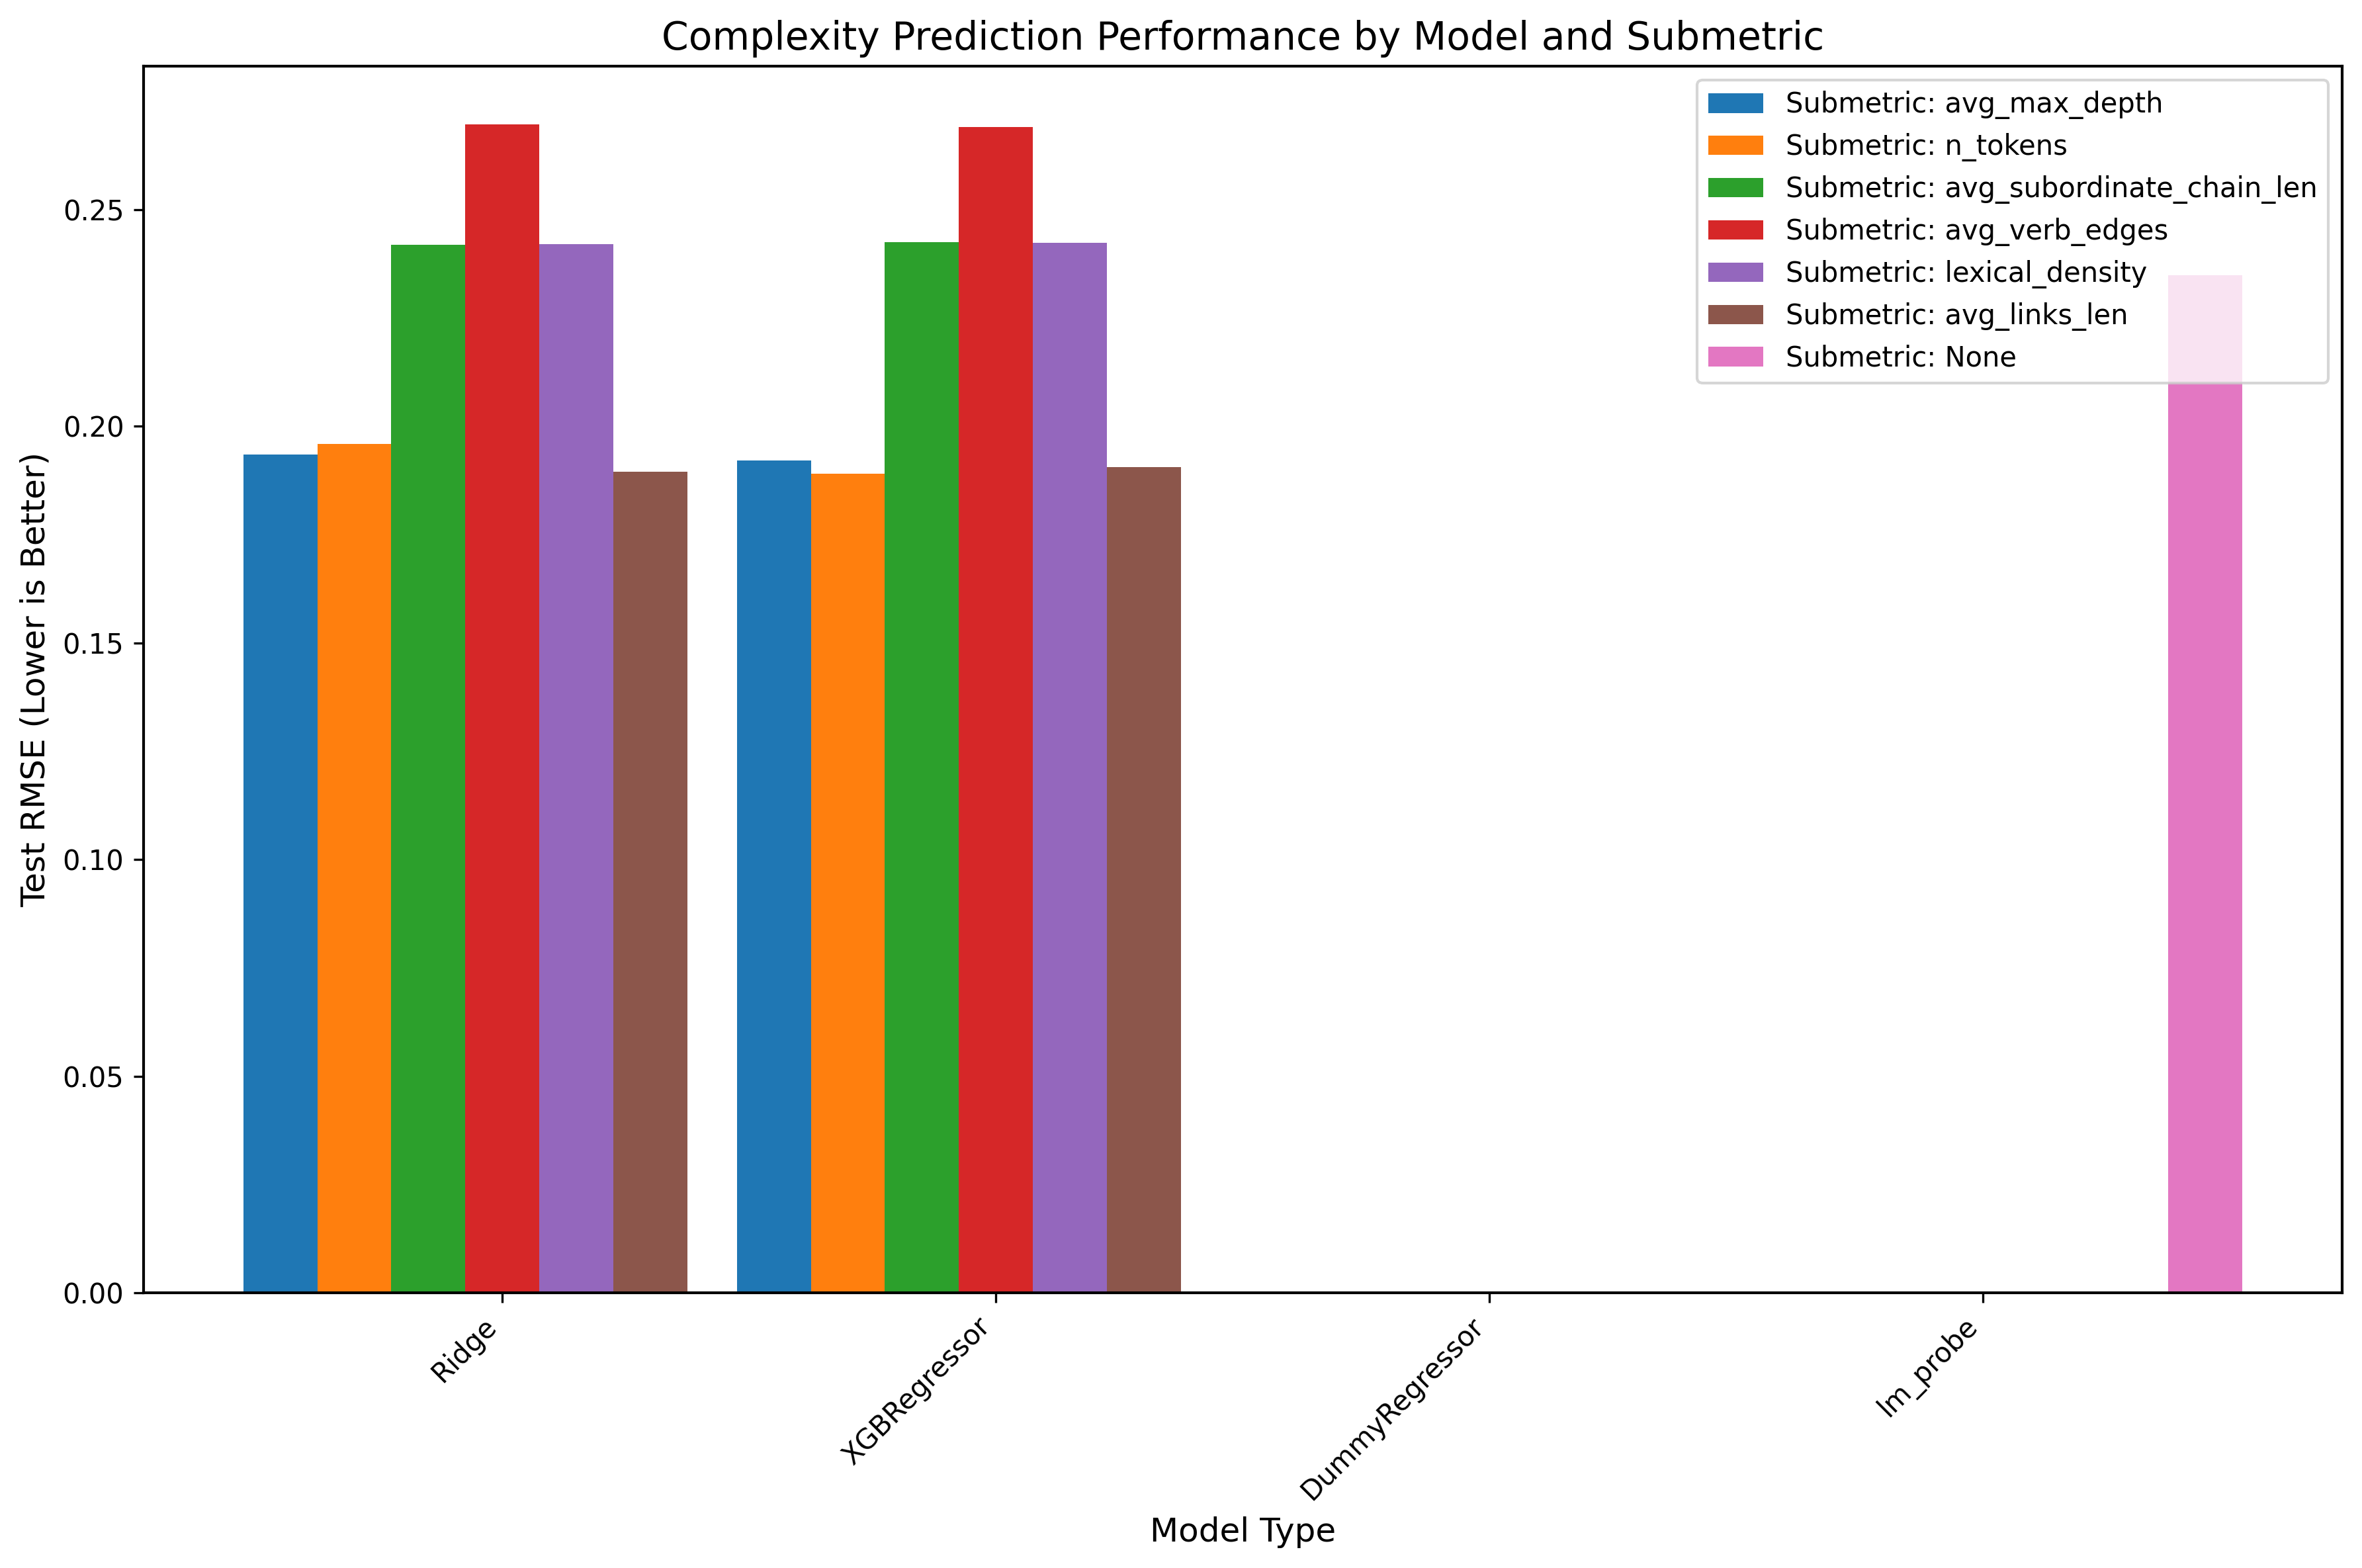

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

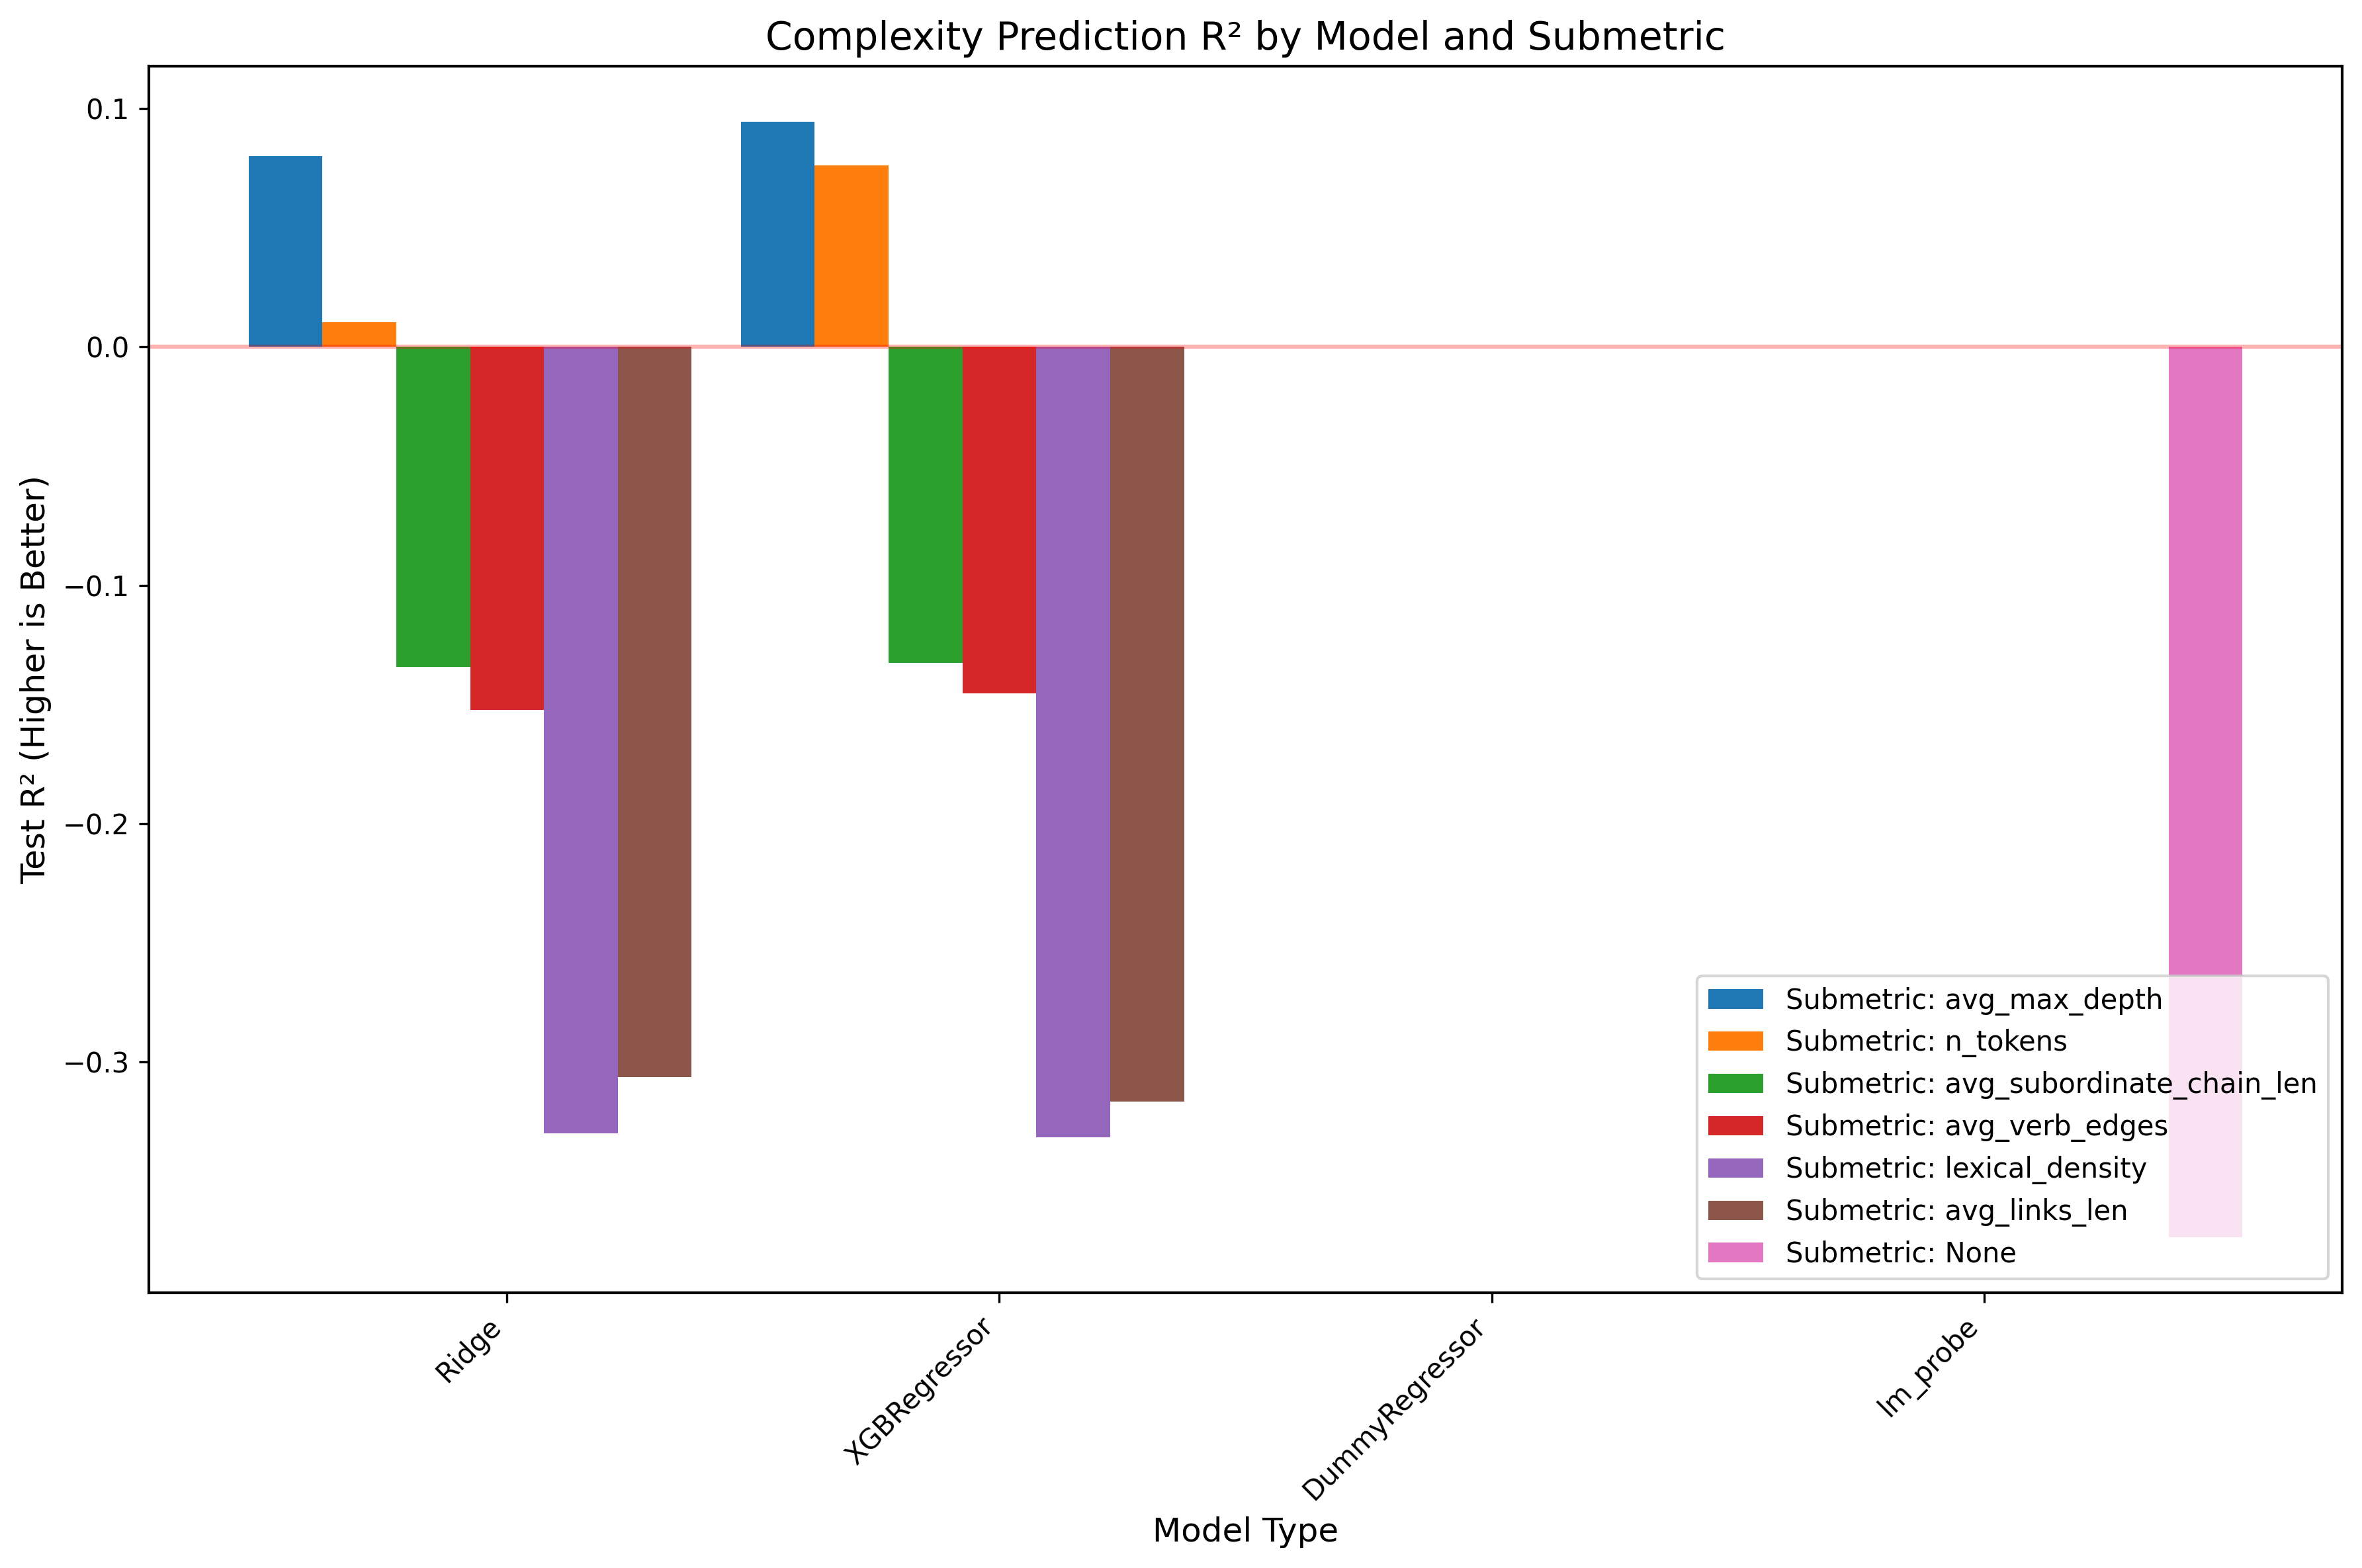

In [8]:
if not complexity_df.empty:
    plt.figure(figsize=(12, 8))
    
    # Group by model and submetric
    grouped = complexity_df.groupby(['model_type', 'submetric'])
    
    # Get unique model types and submetrics for plotting
    model_types = complexity_df['model_type'].unique()
    submetrics_list = [sm for sm in complexity_df['submetric'].unique() if sm is not None]
    
    # Set up bar positions
    bar_width = 0.15
    index = np.arange(len(model_types))
    
    # Plot bars for each submetric
    for i, submetric in enumerate(submetrics_list):
        test_rmse_values = []
        
        for model in model_types:
            subset = complexity_df[(complexity_df['model_type'] == model) & 
                                 (complexity_df['submetric'] == submetric)]
            if not subset.empty:
                test_rmse_values.append(subset['test_rmse'].mean())
            else:
                test_rmse_values.append(0)
        
        plt.bar(index + i*bar_width, test_rmse_values, bar_width, 
                label=f'Submetric: {submetric}')
    
    plt.xlabel('Model Type')
    plt.ylabel('Test RMSE (Lower is Better)')
    plt.title('Complexity Prediction Performance by Model and Submetric')
    plt.xticks(index + bar_width*(len(submetrics_list)-1)/2, model_types, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # R² comparison
    plt.figure(figsize=(12, 8))
    
    for i, submetric in enumerate(submetrics_list):
        test_r2_values = []
        
        for model in model_types:
            subset = complexity_df[(complexity_df['model_type'] == model) & 
                                 (complexity_df['submetric'] == submetric)]
            if not subset.empty:
                test_r2_values.append(subset['test_r2'].mean())
            else:
                test_r2_values.append(0)
        
        plt.bar(index + i*bar_width, test_r2_values, bar_width, 
                label=f'Submetric: {submetric}')
    
    plt.xlabel('Model Type')
    plt.ylabel('Test R² (Higher is Better)')
    plt.title('Complexity Prediction R² by Model and Submetric')
    plt.xticks(index + bar_width*(len(submetrics_list)-1)/2, model_types, rotation=45, ha='right')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()